In [5]:
import os, sys

In [6]:
current_folder_location = os.getcwd()
main_folder = os.path.dirname(current_folder_location)
src = main_folder + '\\SRC'
data = src + '\\DATA'
raw_data = data+ '\\RAW\\'
processed_data = data+ '\\PROCESSED\\'

In [7]:
import pandas as pd
import numpy as np
import glob
import os 
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from keras.layers import Dense, Activation
from keras.models import Sequential

import xgboost as xg

import warnings
warnings.filterwarnings('ignore')

In [8]:
cars = pd.read_csv(raw_data + 'cars.csv')

In [9]:
cars

,manufacturer,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,150,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,20,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,30,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,145,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,145,49.6,1.0,17300
...,...,...,...,...,...,...,...,...,...,...
97707,Volkswagen,Eos,2012,Manual,74000,Diesel,125,58.9,2.0,5990
97708,Volkswagen,Fox,2008,Manual,88102,Petrol,145,46.3,1.2,1799
97709,Volkswagen,Fox,2009,Manual,70000,Petrol,200,42.0,1.4,1590
97710,Volkswagen,Fox,2006,Manual,82704,Petrol,150,46.3,1.2,1250


### DATA CLEANING

In [10]:
cars.isna().sum()

manufacturer    0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

### VIZUALIZATION

<AxesSubplot:xlabel='price'>

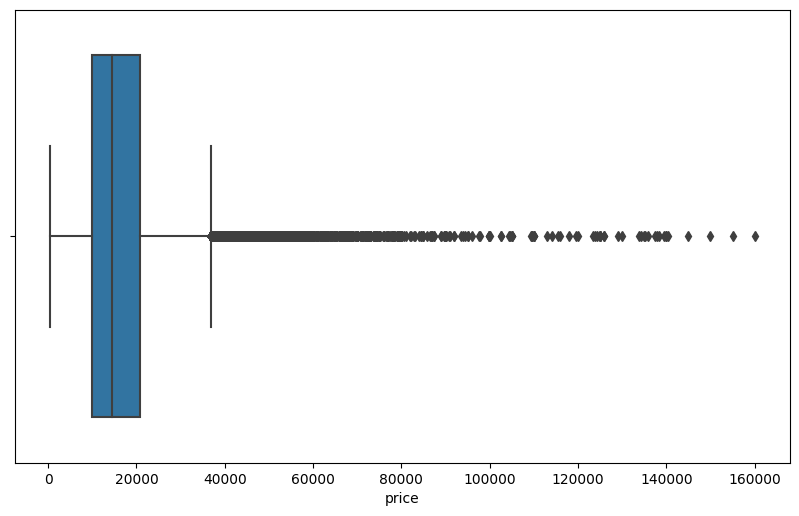

In [11]:
plt.figure(figsize=(10,6), dpi=100)
sns.boxplot(x=cars["price"])

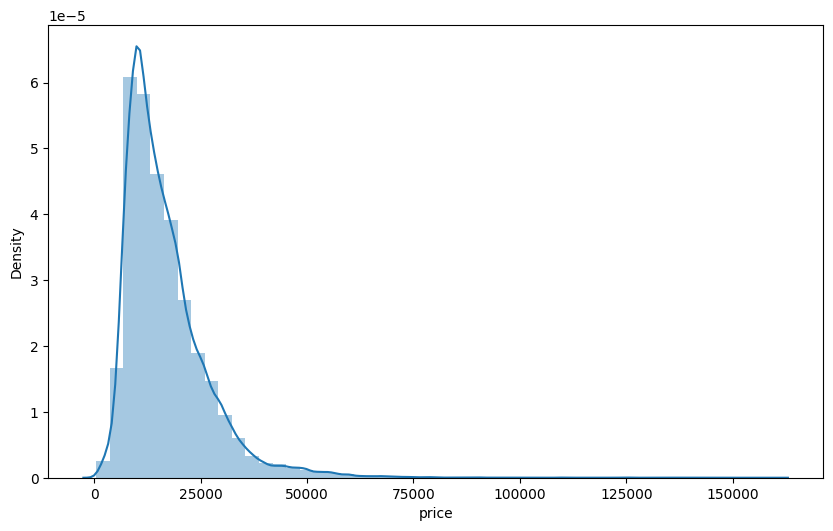

In [12]:
plt.figure(figsize=(10,6), dpi=100)
sns.distplot(cars['price']);


### DATA OBSERVATION

In [13]:
cars.describe()

,year,mileage,tax,mpg,engineSize,price
count,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000
mean,2017.066870,23219.475499,120.142408,55.205623,1.664913,16773.487555
std,2.122993,21060.882301,63.357250,16.181659,0.558574,9868.552222
min,1970.000000,1.000000,0.000000,0.300000,0.000000,450.000000
25%,2016.000000,7673.000000,125.000000,47.100000,1.200000,9999.000000
50%,2017.000000,17682.500000,145.000000,54.300000,1.600000,14470.000000
75%,2019.000000,32500.000000,145.000000,62.800000,2.000000,20750.000000
max,2060.000000,323000.000000,580.000000,470.800000,6.600000,159999.000000


In [14]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97712 entries, 0 to 97711
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  97712 non-null  object 
 1   model         97712 non-null  object 
 2   year          97712 non-null  int64  
 3   transmission  97712 non-null  object 
 4   mileage       97712 non-null  int64  
 5   fuelType      97712 non-null  object 
 6   tax           97712 non-null  int64  
 7   mpg           97712 non-null  float64
 8   engineSize    97712 non-null  float64
 9   price         97712 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 7.5+ MB


#### Creating a Dataframe for the cars at min price

In [15]:
min_car_price = cars[cars['price'] == 450]
print(len(min_car_price))

2


#### Creating a dataframe from min price to first lower quartile

In [16]:
min_to_first_lower_quartile_df = cars[(cars['price'] >= 450) & (cars['price'] <= 9999)]
#min_to_first_lower_quartile_df

### Fraction of min price cars in the dataset

In [17]:
len_df = len(cars)

min_price_car_len = len(min_car_price)

fraction_min_price = min_price_car_len / len_df * 100
print(f'fraction of cars at the min price: {fraction_min_price}') 

print('---------------------------------------------')
min_to_first_lower_quartile_df_len = len(min_to_first_lower_quartile_df)
fraction_min_lower_qr_ = min_to_first_lower_quartile_df_len / len_df * 100
print(f'fraction of cars at the min to quartile: {fraction_min_lower_qr_}') 


fraction of cars at the min price: 0.0020468315048305223
---------------------------------------------
fraction of cars at the min to quartile: 25.146348452595387


## MACHINE LEARNING 

### Feature Engineering 

##### CREATING A DATAFRAME FOR ML

In [18]:
cars_ml = cars.copy()

In [19]:
cars_ml

,manufacturer,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,150,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,20,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,30,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,145,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,145,49.6,1.0,17300
...,...,...,...,...,...,...,...,...,...,...
97707,Volkswagen,Eos,2012,Manual,74000,Diesel,125,58.9,2.0,5990
97708,Volkswagen,Fox,2008,Manual,88102,Petrol,145,46.3,1.2,1799
97709,Volkswagen,Fox,2009,Manual,70000,Petrol,200,42.0,1.4,1590
97710,Volkswagen,Fox,2006,Manual,82704,Petrol,150,46.3,1.2,1250


In [20]:
from sklearn.preprocessing import LabelEncoder

categ = ['manufacturer', 'model', 'transmission', 'fuelType']

# Encode Categorical Columns
le = LabelEncoder()
cars_ml[categ] = cars_ml[categ].apply(le.fit_transform)

#### CREATING A NEW DATAFRAME FOR ML

In [21]:
X = cars_ml.drop(['price'], axis=1)
y = cars_ml['price']

#### Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### LINEAR REGRESSION

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

train_predictions_lin_reg = lin_reg.predict(X_train)
print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, train_predictions_lin_reg))
print('MSE train', mean_squared_error(y_train, train_predictions_lin_reg))
print('RMSE train', np.sqrt(mean_squared_error(y_train, train_predictions_lin_reg)))
print('R2 score', r2_score(y_train, train_predictions_lin_reg))

print('----------------------------------------------')

test_predictions_lin_reg = lin_reg.predict(X_test)


MAE_lin_reg = mean_absolute_error(y_test, test_predictions_lin_reg)
#print(MAE_lin_reg)
rmse_lin_reg = np.sqrt(mean_squared_error(y_test, test_predictions_lin_reg))


print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, test_predictions_lin_reg))
print('MSE test', mean_squared_error(y_test, test_predictions_lin_reg))
print('RMSE test', np.sqrt(mean_squared_error(y_test, test_predictions_lin_reg)))
print('R2 score', r2_score(y_test, test_predictions_lin_reg))


The model performance for training set
--------------------------------------
MAE train 3480.7508469352224
MSE train 27380472.053613234
RMSE train 5232.635287655087
R2 score 0.7182307972323712
----------------------------------------------
The model performance for test set
MAE test 3465.632717319487
MSE test 27267526.288443908
RMSE test 5221.831698594269
R2 score 0.7224436997265196


#### POlYNOMIAL REGRESSION

In [24]:
poly_reg = PolynomialFeatures(degree=2)
poly_reg.fit(X_train)
X_poly = poly_reg.transform(X_train)

pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

## Creating Predictions for Training set 
train_predictions_polyfeatures = pol_reg.predict(X_poly)

print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, train_predictions_polyfeatures))
print('MSE train', mean_squared_error(y_train, train_predictions_polyfeatures))
print('RMSE train', np.sqrt(mean_squared_error(y_train, train_predictions_polyfeatures)))
print('R2 score', r2_score(y_train, train_predictions_polyfeatures))

print('--------------------------------------------------')

X_poly_test = poly_reg.transform(X_test)

# Creating Predictions for Test set 
test_predictions_polyfeatures = pol_reg.predict(X_poly_test)

MAE_poly_reg = mean_absolute_error(y_test, test_predictions_polyfeatures)
rmse_poly_reg = np.sqrt(mean_squared_error(y_test, test_predictions_polyfeatures))
#print(MAE_poly_reg)

print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, test_predictions_polyfeatures))
print('MSE test', mean_squared_error(y_test, test_predictions_polyfeatures))
print('RMSE test', np.sqrt(mean_squared_error(y_test, test_predictions_polyfeatures)))
print('R2 score', r2_score(y_test, test_predictions_polyfeatures))

The model performance for training set
--------------------------------------
MAE train 2689.711333925957
MSE train 17544484.574138008
RMSE train 4188.613681653873
R2 score 0.8194517822138327
--------------------------------------------------
The model performance for test set
MAE test 2663.901754908833
MSE test 17514342.61687457
RMSE test 4185.014052171697
R2 score 0.8217214100377688


#### Scaling the DATA

In [25]:
#calling an instance of StandardScaler 
scaler = StandardScaler()

#transforming the X_train and X_test 

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Ridge with Alpha 100

In [26]:
from sklearn.linear_model import Ridge
ridge_model_with_alpha100 = Ridge(alpha=100)
ridge_model_with_alpha100.fit(X_train_scaled, y_train)

# Creating predictions for Training set 
train_predictions_for_ridge_model_with_alpha100 = ridge_model_with_alpha100.predict(X_train_scaled)

print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, train_predictions_for_ridge_model_with_alpha100))
print('MSE train', mean_squared_error(y_train, train_predictions_for_ridge_model_with_alpha100))
print('RMSE train', np.sqrt(mean_squared_error(y_train, train_predictions_for_ridge_model_with_alpha100)))
print('R2 score', r2_score(y_train, train_predictions_for_ridge_model_with_alpha100))

test_predictions_for_ridge_model_with_alpha100 = ridge_model_with_alpha100.predict(X_test_scaled)

MAE_ridge_alpha_100 = mean_absolute_error(y_test, test_predictions_for_ridge_model_with_alpha100)
rmse_ridge_alpha_100 = np.sqrt(mean_squared_error(y_test, test_predictions_for_ridge_model_with_alpha100))
#print(MAE_ridge_alpha_100)

print('--------------------------------------------')
print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, test_predictions_for_ridge_model_with_alpha100))
print('MSE test', mean_squared_error(y_test, test_predictions_for_ridge_model_with_alpha100))
print('RMSE test', np.sqrt(mean_squared_error(y_test, test_predictions_for_ridge_model_with_alpha100)))
print('R2 score', r2_score(y_test, test_predictions_for_ridge_model_with_alpha100))

The model performance for training set
--------------------------------------
MAE train 3480.3624142413846
MSE train 27380645.273382217
RMSE train 5232.651839496129
R2 score 0.7182290146481953
--------------------------------------------
The model performance for test set
MAE test 3465.3020677311356
MSE test 27269480.090132084
RMSE test 5222.018775352314
R2 score 0.7224238119683746


### Ridge via Grid Search

In [27]:
ridge_for_grid_search = Ridge()
parameters = {'alpha': np.arange(0.0001, 1), "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

Ridge_GS = GridSearchCV(ridge_for_grid_search, param_grid=parameters, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

Ridge_GS.fit(X_train_scaled, y_train)

Ridge_GS_train_prediction = Ridge_GS.predict(X_train_scaled)

print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, Ridge_GS_train_prediction))
print('MSE train', mean_squared_error(y_train, Ridge_GS_train_prediction))
print('RMSE train', np.sqrt(mean_squared_error(y_train, Ridge_GS_train_prediction)))
print('R2 score', r2_score(y_train, Ridge_GS_train_prediction))

print('--------------------------------------')

#print(f'best params: {Ridge_GS.best_params_}')
Ridge_GS_predictions = Ridge_GS.predict(X_test_scaled)

MAE_Ridge_GS_predictions = mean_absolute_error(y_test, Ridge_GS_predictions)
rmse_ridge_GS = np.sqrt(mean_squared_error(y_test, Ridge_GS_predictions))
#print(MAE_Ridge_GS_predictions)

print('-----------------------------------------')
print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, Ridge_GS_predictions))
print('MSE test', mean_squared_error(y_test, Ridge_GS_predictions))
print('RMSE test', np.sqrt(mean_squared_error(y_test, Ridge_GS_predictions)))
print('R2 score', r2_score(y_test, Ridge_GS_predictions))

The model performance for training set
--------------------------------------
MAE train 3480.8950219788653
MSE train 27380516.14356228
RMSE train 5232.639500630851
R2 score 0.7182303435079149
--------------------------------------
-----------------------------------------
The model performance for test set
MAE test 3465.8313050897327
MSE test 27266822.027536314
RMSE test 5221.764263880199
R2 score 0.7224508684021769


## Elastic NET CV

In [28]:
from sklearn.linear_model import ElasticNetCV
elastic_model = ElasticNetCV(l1_ratio= [.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=100, max_iter=1000000)
elastic_model.fit(X_train_scaled, y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000000)

In [29]:
train_predictions_elastic_net_cv = elastic_model.predict(X_train_scaled)

print('The model performance for training set')
print('MAE train', mean_absolute_error(y_train, train_predictions_elastic_net_cv))
print('MSE train', mean_squared_error(y_train, train_predictions_elastic_net_cv))
print('RMSE train', np.sqrt(mean_squared_error(y_train, train_predictions_elastic_net_cv)))
print('R2 score', r2_score(y_train, train_predictions_elastic_net_cv))

test_predictions_elastic_net_cv = elastic_model.predict(X_test_scaled)

MAE_elastic_net_cv = mean_absolute_error(y_test, test_predictions_elastic_net_cv)
rmse_elastic_net_cv = np.sqrt(mean_squared_error(y_test, test_predictions_elastic_net_cv))

print('--------------------------------------------')
print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, test_predictions_elastic_net_cv))
print('MSE test', mean_squared_error(y_test, test_predictions_elastic_net_cv))
print('RMSE test', np.sqrt(mean_squared_error(y_test, test_predictions_elastic_net_cv)))
print('R2 score', r2_score(y_test, test_predictions_elastic_net_cv))

The model performance for training set
MAE train 3480.4869479967106
MSE train 27381017.762932986
RMSE train 5232.687432183675
R2 score 0.7182251814022398
--------------------------------------------
The model performance for test set
MAE test 3465.391820469886
MSE test 27271158.7511044
RMSE test 5222.1795019995625
R2 score 0.7224067248690915


### Elastic NET via GRID SEARCH 

In [30]:
from sklearn.linear_model import ElasticNet

elastic_net_model_2 = ElasticNet()

parameters = {'alpha': [0.1, 1, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200], 'l1_ratio': np.arange(0.1, 1.5)} #this is used as a param_grid in elastic Search 
grid_search_model = GridSearchCV(estimator=elastic_net_model_2, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')

grid_search_model.fit(X_train_scaled, y_train)
#print(f'best params: {grid_search_model.best_params_}')


train_predictions_elastic_net_cv_via_GS = grid_search_model.predict(X_train_scaled)
print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, train_predictions_elastic_net_cv_via_GS))
print('MSE train', mean_squared_error(y_train, train_predictions_elastic_net_cv_via_GS))
print('RMSE train', np.sqrt(mean_squared_error(y_train, train_predictions_elastic_net_cv_via_GS)))
print('R2 score', r2_score(y_train, train_predictions_elastic_net_cv_via_GS))

print('-------------------------------------------')

test_predictions_via_Grid_search_elastic_net = grid_search_model.predict(X_test_scaled)

MAE_GS_elastic_net = mean_absolute_error(y_test, test_predictions_via_Grid_search_elastic_net)
rmse_GS_elastic_net_cv = np.sqrt(mean_squared_error(y_test, test_predictions_via_Grid_search_elastic_net))

print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, test_predictions_via_Grid_search_elastic_net))
print('MSE test', mean_squared_error(y_test, test_predictions_via_Grid_search_elastic_net))
print('RMSE test', np.sqrt(mean_squared_error(y_test, test_predictions_via_Grid_search_elastic_net)))
print('R2 score', r2_score(y_test, test_predictions_via_Grid_search_elastic_net))

The model performance for training set
--------------------------------------
MAE train 3488.622013696916
MSE train 27950466.614862986
RMSE train 5286.820085350265
R2 score 0.712365050550183
-------------------------------------------
The model performance for test set
MAE test 3475.2811411624484
MSE test 27948805.455193266
RMSE test 5286.662979157388
R2 score 0.7155089553358452


### RANDOM FOREST 

In [31]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
Random_regressor_forest = RandomForestRegressor(n_estimators = 100, random_state = 42)

# fit the regressor with x and y data
Random_regressor_forest.fit(X_train_scaled, y_train)

random_forest_train_predictions = Random_regressor_forest.predict(X_train_scaled)
print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, random_forest_train_predictions))
print('MSE train', mean_squared_error(y_train, random_forest_train_predictions))
print('RMSE train', np.sqrt(mean_squared_error(y_train, random_forest_train_predictions)))
print('R2 score', r2_score(y_train, random_forest_train_predictions))

print('------------------------------------------------------')

random_forest_predictions = Random_regressor_forest.predict(X_test_scaled)


MAE_radom_forest = mean_absolute_error(y_test, random_forest_predictions)
rmse_random_forest = np.sqrt(mean_squared_error(y_test, random_forest_predictions))

print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, random_forest_predictions))
print('MSE test', mean_squared_error(y_test, random_forest_predictions))
print('RMSE test', np.sqrt(mean_squared_error(y_test, random_forest_predictions)))
print('R2 score', r2_score(y_test, random_forest_predictions))

The model performance for training set
--------------------------------------
MAE train 446.0421893078539
MSE train 628042.6367162551
RMSE train 792.4914111309063
R2 score 0.9935368874318489
------------------------------------------------------
The model performance for test set
MAE test 1167.872759982767
MSE test 3974671.4347803574
RMSE test 1993.65780282885
R2 score 0.9595417975737732


### XG boost

In [32]:
# Instantiation
xgboost_model = xg.XGBRegressor(n_estimators = 10, seed = 123)
xgboost_model.fit(X_train_scaled, y_train)

xgboost_model_preds_train = xgboost_model.predict(X_train_scaled)
print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, xgboost_model_preds_train))
print('MSE train', mean_squared_error(y_train, xgboost_model_preds_train))
print('RMSE train', np.sqrt(mean_squared_error(y_train, xgboost_model_preds_train)))
print('R2 score', r2_score(y_train, xgboost_model_preds_train))

xgboost_model_preds_test = xgboost_model.predict(X_test_scaled)

MAE_xgboost_model= mean_absolute_error(y_test, xgboost_model_preds_test)
rmse_xgboost_model = np.sqrt(mean_squared_error(y_test, xgboost_model_preds_test))
#print(MAE_xgboost_model)

print('---------------------------------------')
print('MAE test', mean_absolute_error(y_test, xgboost_model_preds_test))
print('MSE test', mean_squared_error(y_test, xgboost_model_preds_test))
print('RMSE test', np.sqrt(mean_squared_error(y_test, xgboost_model_preds_test)))
print('R2 score', r2_score(y_test, xgboost_model_preds_test))

The model performance for training set
--------------------------------------
MAE train 1856.490625208008
MSE train 7813865.0292718485
RMSE train 2795.3291450689394
R2 score 0.9195884382299669
---------------------------------------
MAE test 1851.3071299118951
MSE test 7698389.651579035
RMSE test 2774.5972052856673
R2 score 0.921638049335576


### GRADIENT BOOSTING

In [33]:
gradient_booster_model = GradientBoostingRegressor()
gradient_booster_model.fit(X_train_scaled, y_train)

gradient_booster_model_predictions_train = gradient_booster_model.predict(X_train_scaled)
print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, gradient_booster_model_predictions_train))
print('MSE train', mean_squared_error(y_train, gradient_booster_model_predictions_train))
print('RMSE train', np.sqrt(mean_squared_error(y_train, gradient_booster_model_predictions_train)))
print('R2 score', r2_score(y_train, gradient_booster_model_predictions_train))

gradient_booster_model_preds_test = gradient_booster_model.predict(X_test_scaled)

MAE_gradient_booster = mean_absolute_error(y_test, gradient_booster_model_preds_test)
rmse_gradient_booster = np.sqrt(mean_squared_error(y_test, gradient_booster_model_preds_test))

print('---------------------------------------------------')
print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, gradient_booster_model_preds_test))
print('MSE test', mean_squared_error(y_test, gradient_booster_model_preds_test))
print('RMSE test', np.sqrt(mean_squared_error(y_test, gradient_booster_model_preds_test)))
print('R2 score', r2_score(y_test, gradient_booster_model_preds_test))

The model performance for training set
--------------------------------------
MAE train 2027.123797044726
MSE train 9155051.497422414
RMSE train 3025.731564006036
R2 score 0.9057864467539417
---------------------------------------------------
The model performance for test set
MAE test 2014.833851598048
MSE test 8962154.34797479
RMSE test 2993.685746362632
R2 score 0.9087741815304315


### CATBOOST

In [34]:
cat_boost_model = CatBoostRegressor()
cat_boost_model.fit(X_train_scaled, y_train)


cat_boost_model_preds_train = cat_boost_model.predict(X_train_scaled)
print('The model performance for training set')
print('--------------------------------------')
print('MAE train', mean_absolute_error(y_train, cat_boost_model_preds_train))
print('MSE train', mean_squared_error(y_train, cat_boost_model_preds_train))
print('RMSE train', np.sqrt(mean_squared_error(y_train, cat_boost_model_preds_train)))
print('R2 score', r2_score(y_train, cat_boost_model_preds_train))


cat_boost_model_preds_test = cat_boost_model.predict(X_test_scaled)

MAE_catboost_model = mean_absolute_error(y_test, cat_boost_model_preds_test)
rmse_catboost_model = np.sqrt(mean_squared_error(y_test, cat_boost_model_preds_test))

print('-----------------------------------------------')
print('The model performance for test set')
print('MAE test', mean_absolute_error(y_test, cat_boost_model_preds_test))
print('MSE test', mean_squared_error(y_test, cat_boost_model_preds_test))
print('RMSE test', np.sqrt(mean_squared_error(y_test, cat_boost_model_preds_test)))
print('R2 score', r2_score(y_test, cat_boost_model_preds_test))

Learning rate set to 0.081523
0:	learn: 9270.9750730	total: 210ms	remaining: 3m 29s
1:	learn: 8749.6716053	total: 226ms	remaining: 1m 52s
2:	learn: 8270.3909783	total: 234ms	remaining: 1m 17s
3:	learn: 7848.0291662	total: 243ms	remaining: 1m
4:	learn: 7454.0198439	total: 251ms	remaining: 50s
5:	learn: 7093.8535727	total: 258ms	remaining: 42.7s
6:	learn: 6775.0098312	total: 263ms	remaining: 37.3s
7:	learn: 6484.9608745	total: 267ms	remaining: 33.2s
8:	learn: 6225.2471643	total: 272ms	remaining: 29.9s
9:	learn: 5993.6574517	total: 276ms	remaining: 27.4s
10:	learn: 5784.8441448	total: 282ms	remaining: 25.3s
11:	learn: 5577.0932139	total: 286ms	remaining: 23.6s
12:	learn: 5406.4374477	total: 291ms	remaining: 22.1s
13:	learn: 5241.0887746	total: 295ms	remaining: 20.8s
14:	learn: 5089.0179483	total: 299ms	remaining: 19.7s
15:	learn: 4954.6411924	total: 304ms	remaining: 18.7s
16:	learn: 4834.4319042	total: 308ms	remaining: 17.8s
17:	learn: 4715.6968280	total: 313ms	remaining: 17.1s
18:	learn:

In [35]:
cat_boost_model.feature_importances_

array([ 8.88314212, 11.75352662, 22.45091963,  6.10572554,  6.62262377,
        1.31422119,  0.36501479,  8.02632494, 34.47850139])

### FEATURES ON BEST MODEL (CATBOOST MODEL)

In [36]:
#creating a dictionary for Features and Importance based on mid_high category Dataframe
my_dict_mid_high={"Features": ['manufacturer', 'model', 'year', 'transmission', 'mileage', 'fuelType',
       'tax', 'mpg', 'engineSize'],"importances": cat_boost_model.feature_importances_}

In [37]:
df_features=pd.DataFrame(my_dict_mid_high).sort_values('importances', ascending=False)
df_features

,Features,importances
8,engineSize,34.478501
2,year,22.450920
1,model,11.753527
0,manufacturer,8.883142
7,mpg,8.026325
4,mileage,6.622624
3,transmission,6.105726
5,fuelType,1.314221
6,tax,0.365015


([<matplotlib.axis.XTick at 0x26e90e14490>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

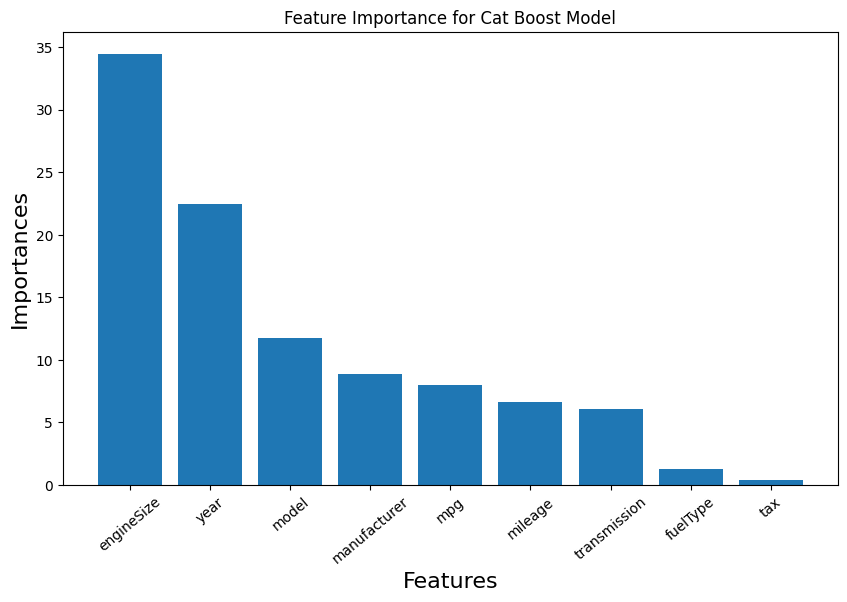

In [38]:
features= df_features['Features']
importances = df_features['importances']

# Create bars
plt.figure(figsize=(10,6), dpi=100)
plt.bar(features, importances)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Importances', fontsize=16)
plt.title('Feature Importance for Cat Boost Model')
# Create names on the x-axis
plt.xticks(features, rotation=40)

### Creating a dictionary, Followed by dataframe

In [39]:
mae_test_dictionary = {'lin_reg_model': MAE_lin_reg, 'Polynomial': MAE_poly_reg, 'ridge': MAE_ridge_alpha_100, 
'Elast_net_CV': MAE_elastic_net_cv,'Random_forest': MAE_radom_forest, 'xg_boost': MAE_xgboost_model, 'grad_boost': MAE_gradient_booster, 'catboost': MAE_catboost_model}

mae_test_results = pd.DataFrame.from_dict(mae_test_dictionary, orient='index')
mae_test_results = mae_test_results.reset_index()
mae_test_results.rename(columns={ 'index': 'Model', 0: 'MAE TEST SCORE'}, inplace=True)
mae_test_results = mae_test_results.sort_values(by='MAE TEST SCORE', ascending=False)
mae_test_results

,Model,MAE TEST SCORE
0,lin_reg_model,3465.632717
3,Elast_net_CV,3465.391820
2,ridge,3465.302068
1,Polynomial,2663.901755
6,grad_boost,2014.833852
5,xg_boost,1851.307130
7,catboost,1214.927740
4,Random_forest,1167.872760


In [40]:
rmse_test_dictionary = {'lin_reg_model': rmse_lin_reg, 'Polynomial': rmse_lin_reg, 'ridge': rmse_ridge_alpha_100, 
'Elast_net_CV': rmse_elastic_net_cv,'Random_forest': rmse_random_forest, 'xg_boost': rmse_xgboost_model, 'grad_boost': rmse_gradient_booster, 'catboost': rmse_catboost_model}

rmse_test_results = pd.DataFrame.from_dict(rmse_test_dictionary, orient='index')
rmse_test_results = rmse_test_results.reset_index()
rmse_test_results.rename(columns={ 'index': 'Model', 0: 'RMSE TEST SCORE'}, inplace=True)
rmse_test_results = rmse_test_results.sort_values(by='RMSE TEST SCORE', ascending=False)
rmse_test_results


,Model,RMSE TEST SCORE
3,Elast_net_CV,5222.179502
2,ridge,5222.018775
0,lin_reg_model,5221.831699
1,Polynomial,5221.831699
6,grad_boost,2993.685746
5,xg_boost,2774.597205
4,Random_forest,1993.657803
7,catboost,1858.703278


### Graphing the MAE results and RMSE results 

Text(0.5, 0.98, 'Comparison of MAE and RMSE results on models')

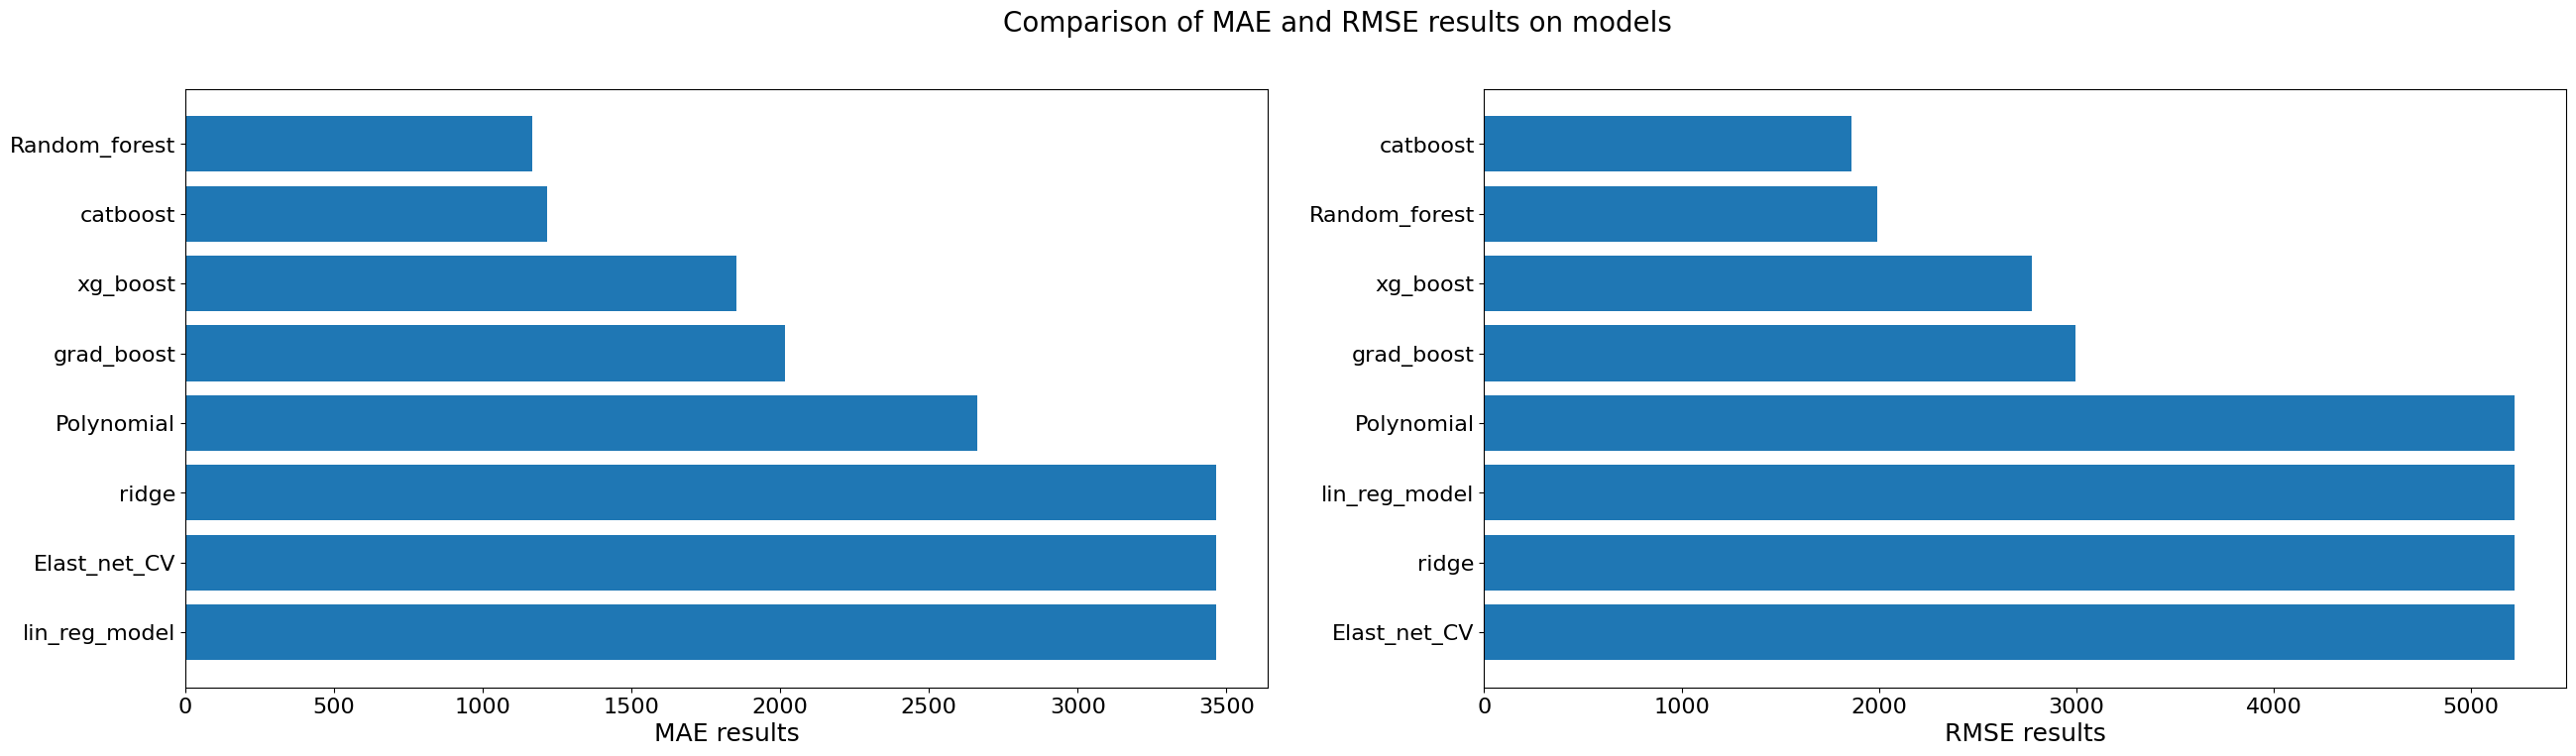

In [41]:

mae_model_type = mae_test_results['Model']
mae_results = mae_test_results['MAE TEST SCORE']

rmse_model_type = rmse_test_results['Model']
rmse_results = rmse_test_results['RMSE TEST SCORE']


plt.figure(figsize=(31,8), dpi=100)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.barh(mae_model_type, mae_results)
plt.xlabel('MAE results', fontsize=18)
#plt.xlabel('Outbound countries', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Total # of Passangers arriving from Top 10 countries in 2018' , fontsize=18)


plt.subplot(1, 2, 2) # index 2
plt.barh(rmse_model_type, rmse_results)
plt.xlabel('RMSE results', fontsize=18)
    #plt.xlabel('Outbound Country', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

    # creating a title for both graphs 
plt.suptitle('Comparison of MAE and RMSE results on models',fontsize=20)